<a href="https://colab.research.google.com/github/AsutoshDalei/Deep-Neural-Networks/blob/master/Delhi_Climate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Delhi's climate analysis and forecast using LSTM networks
### This dataset provides weather data from 1st January 2013 to 24th April 2017 in the city of Delhi, India.
#### We aim to analyze the variation in Delhi's climate on a day to day basis and attempt to build a model strong enough to forecast the future variations accurately
This dataset has been collected by Weather Undergroud API.

#### We import the nesessary packages followed by the dataset itself. We parse the dates while importing the dataset.

In [0]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [188]:
from google.colab import files
import io

uploaded = files.upload()

Saving DailyDelhiClimate.csv to DailyDelhiClimate (1).csv


In [189]:
df= pd.read_csv(io.BytesIO(uploaded['DailyDelhiClimate.csv']),index_col='date',parse_dates=True)
df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


#### Checking for any 'NaN' instances in our dataset

In [0]:
np.isnan(df).sum()

meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

## Visualization of climate variation

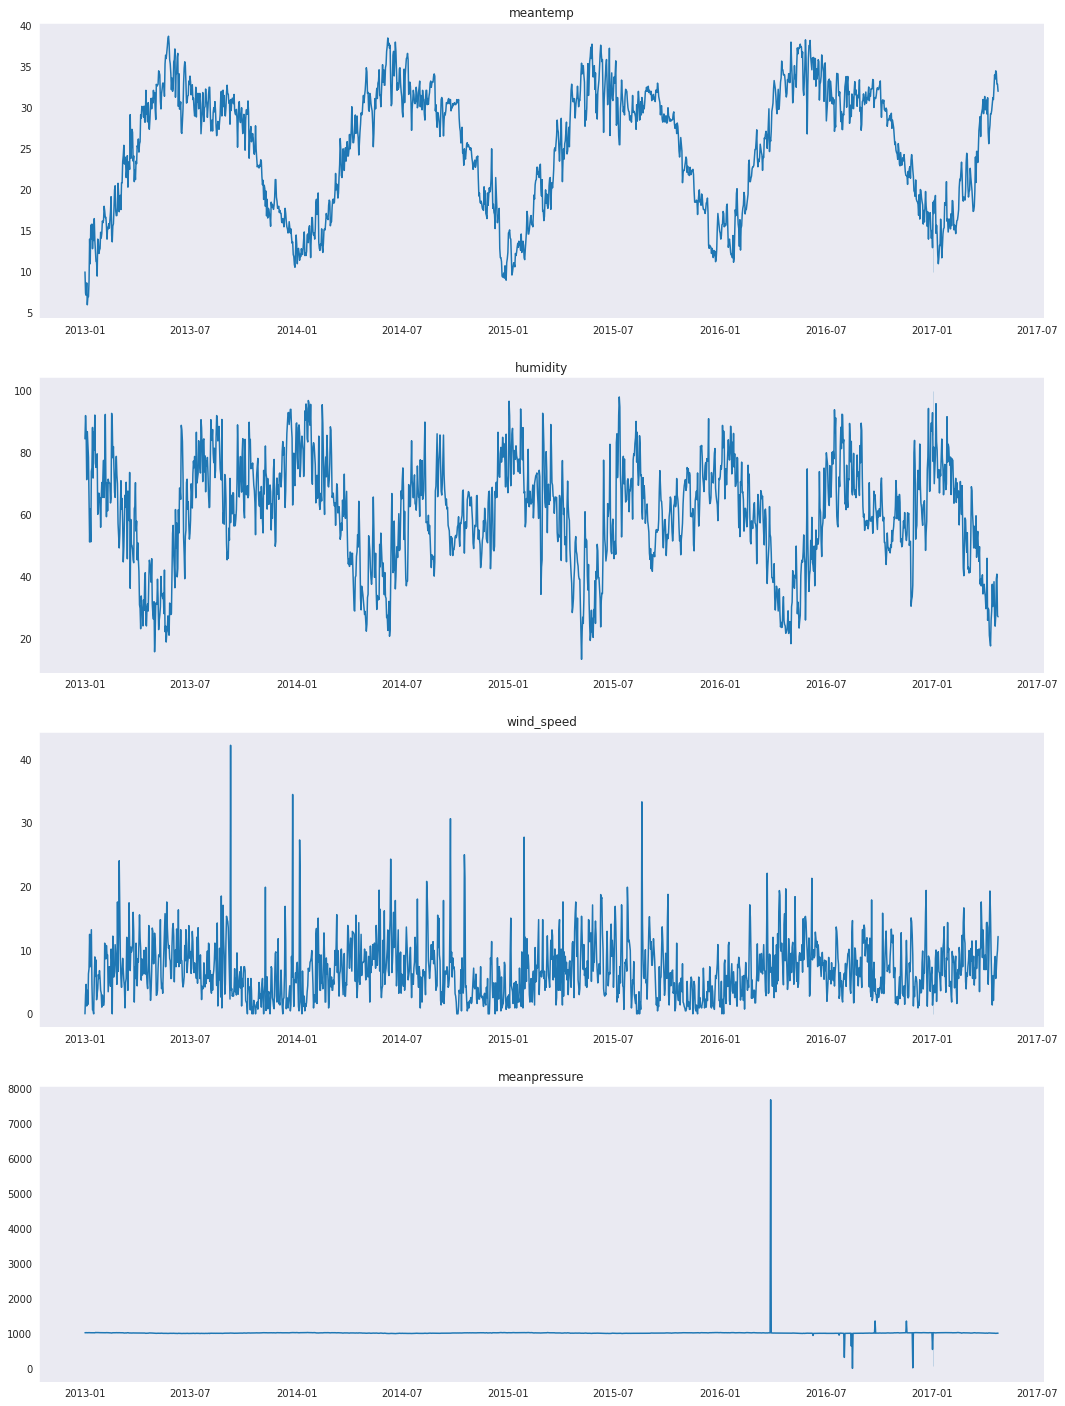

In [0]:
_,_=plt.subplots(figsize=(18,25))
sns.set_style('dark')
for i in range(df.shape[1]):
    name=df.columns[i]
    plt.subplot(df.shape[1],1,i+1)
    plt.title(name)
    sns.lineplot(data=df[name])
plt.show()

### For this analysis, let us focus on the mean temperature of Delhi.
#### Here, we observe the variation of the mean temperature of Delhi over the years from 2013 to 2016. This would be our training data.
#### The year 2017, will be our testing data

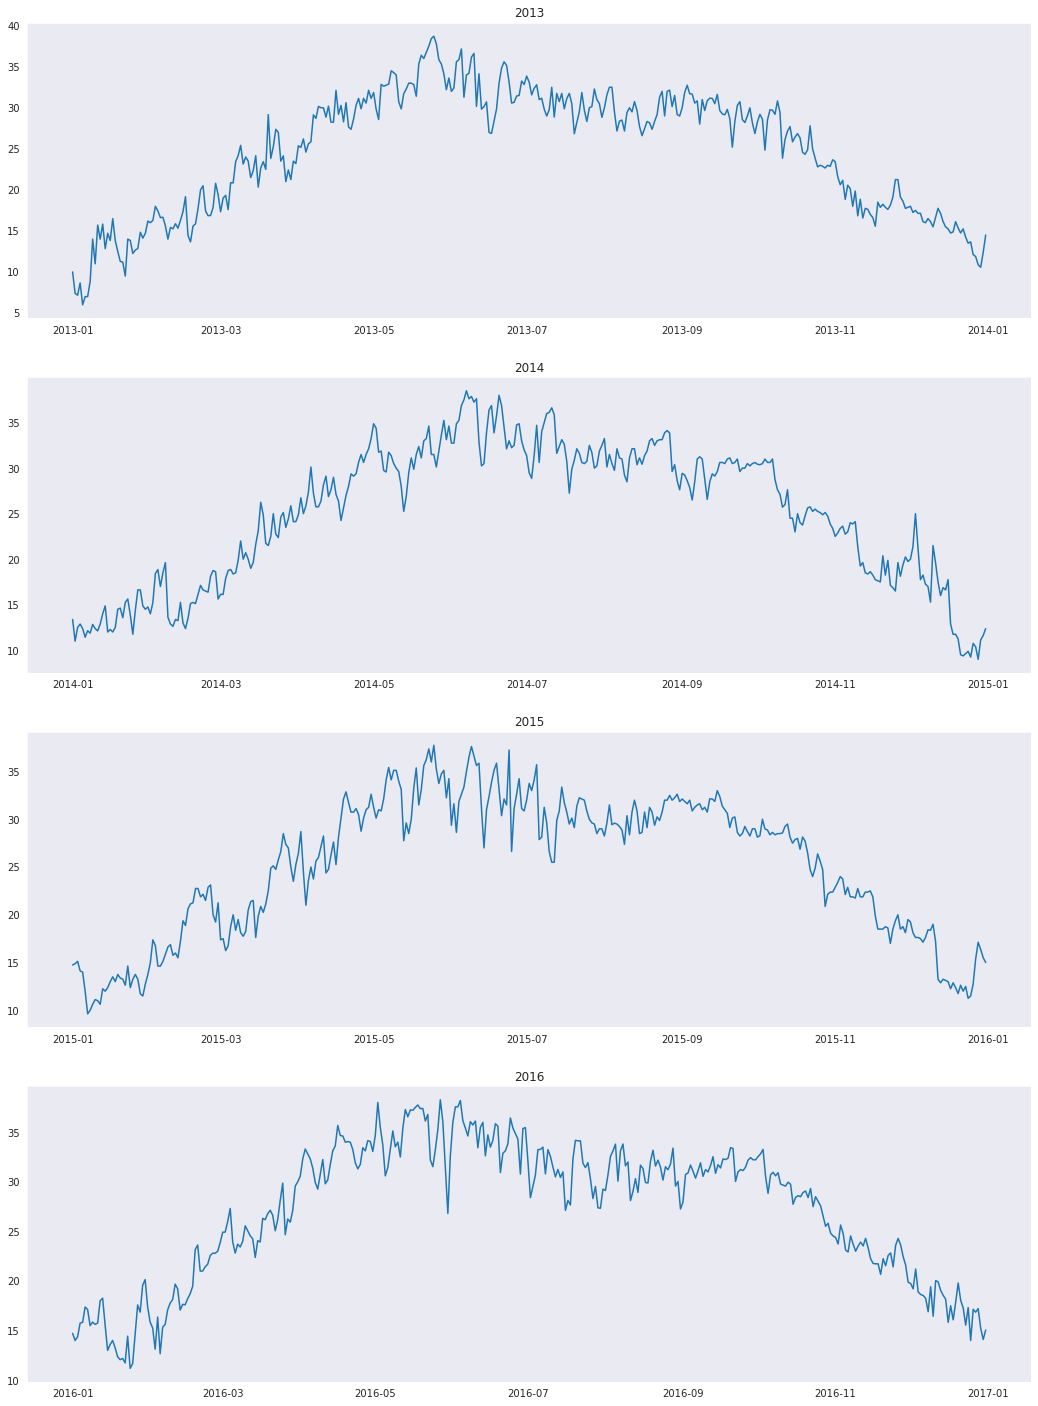

In [190]:
years=['2013','2014','2015','2016']
_,_=plt.subplots(figsize=(18,25))
sns.set_style('dark')
for i in range(len(years)):
    yr=years[i]
    plt.subplot(len(years),1,i+1)
    plt.title(yr)
    sns.lineplot(data=df[str(yr)]['meantemp'])
plt.show()

### Resampling the data to ensure it is in days format.
#### We also define the training data and testing data.

In [0]:
df=df.resample('D').sum()
traindat=df.loc[:'2017-01-01','meantemp']
testdat=df.loc['2016-12-26':,'meantemp']


### Observe that we have divided our dataset in chunks of 7. This represents the 'Mean Temp' values for a week.
#### Note that we have considered an extra week from the training dataset for the testing dataset

In [0]:
xtrain,ytrain=[],[]
for i in range(7,traindat.shape[0]-7):
    xtrain.append(traindat[i-7:i])
    ytrain.append(traindat[i:i+7])
  
xtrain=np.array(xtrain)
ytrain=np.array(ytrain)

sca=preprocessing.MinMaxScaler() 
xtrain=sca.fit_transform(xtrain)
ytrain=sca.fit_transform(ytrain)


Since LSTM models require 3D arrays as inputs, we reshape our xtrain and ytrain into a 3D numpy array

In [222]:
xtrain=xtrain.reshape(1448,7,1)
ytrain=ytrain.reshape(1448,7,1)
xtrain.shape,ytrain.shape

((1448, 7, 1), (1448, 7, 1))

#### Defining a model. The model may be edited per choice to obtain better results. Here, I have considered a simple multi layer LSTM model

In [0]:
model=tf.keras.Sequential([
     tf.keras.layers.LSTM(units=16,activation='relu',input_shape=(7,1),return_sequences=True),
     tf.keras.layers.LSTM(units=32,activation='relu',return_sequences=True),
     tf.keras.layers.LSTM(units=32,activation='relu'),
     tf.keras.layers.Dense(units=16,activation='relu'),
     tf.keras.layers.Dense(7)
                            ])

#### Adam Optimizer is used with a learning rate of 0.0001. We can also include a scheduled learning rate with the help of callbacks

In [226]:
opt=tf.keras.optimizers.Adam(lr=0.0001)
model.compile(loss='mse',optimizer=opt,metrics=['mae'])
model.fit(xtrain,ytrain,epochs=100,batch_size=16)

Epoch 1/100
91/91 [==============================] - 1s 10ms/step - loss: 0.3608 - mae: 0.5496
Epoch 2/100
91/91 [==============================] - 1s 10ms/step - loss: 0.3155 - mae: 0.5072
Epoch 3/100
91/91 [==============================] - 1s 10ms/step - loss: 0.2092 - mae: 0.3906
Epoch 4/100
91/91 [==============================] - 1s 10ms/step - loss: 0.1013 - mae: 0.2451
Epoch 5/100
91/91 [==============================] - 1s 10ms/step - loss: 0.0612 - mae: 0.1843
Epoch 6/100
91/91 [==============================] - 1s 10ms/step - loss: 0.0259 - mae: 0.1173
Epoch 7/100
91/91 [==============================] - 1s 11ms/step - loss: 0.0128 - mae: 0.0890
Epoch 8/100
91/91 [==============================] - 1s 10ms/step - loss: 0.0104 - mae: 0.0803
Epoch 9/100
91/91 [==============================] - 1s 11ms/step - loss: 0.0098 - mae: 0.0775
Epoch 10/100
91/91 [==============================] - 1s 10ms/step - loss: 0.0095 - mae: 0.0765
Epoch 11/100
91/91 [=============================

## Preprocessing the testing data
### We divide the test data into similar 7 days chunks representing a week worth data.
The data is then scaled and presented in a numpy array format

In [0]:
scatest=preprocessing.MinMaxScaler()

xtest,ytest=[],[]
for i in range(7,testdat.shape[0]-7):
    xtest.append(testdat[i-7:i])
    ytest.append(testdat[i:i+7])

xtest=scatest.fit_transform(xtest)
ytest=scatest.transform(ytest)
xtest,ytest=np.array(xtest),np.array(ytest)


In [204]:
testdat.shape
#traindat.tail(7)

(120,)

## Forcasting the test values using predict function

In [228]:
xtest=xtest.reshape(106,7,1)
print(xtest.shape)

ypred=model.predict(xtest)
ypred.shape

(106, 7, 1)


(106, 7)

###Since the data was in a 3D array of chunks of 7 days, using this function, we revert those values properly back into a proper time series based format
We then inverse transform them and present it in a numpy array format

In [0]:
def revert(data):
    l=[]
    for i in range(len(data)):
        l.append(data[i][0])
    for j in range(1,data.shape[1]):
        l.append(data[-1][j])
    #l.append(data[-1][-1])
    return(l)


ypre=scatest.inverse_transform(ypred)
ytes=scatest.inverse_transform(ytest)

ypred1=np.array(revert(ypre))
ytest1=np.array(revert(ytes))

## We visualize how our model made a forecast on the unknown testing data.
#### This is similar to predicting the variation to follow up ahead
Our model comes up with a smooth curve when compared to the sharp curve of test values

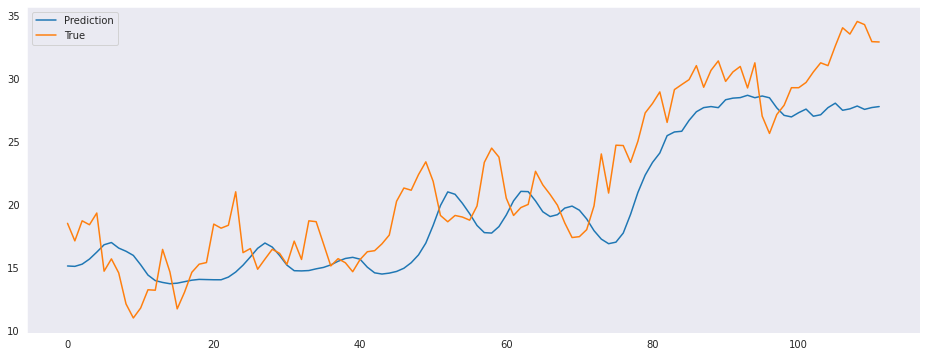

In [208]:
plt.figure(figsize=(16,6))
plt.plot(ypred1,label='Prediction')
plt.plot(ytest1,label='True')
plt.legend()
plt.show()

In [213]:
preddf=pd.DataFrame(ypred1,df['2016-12-26':'2017-04-16'].index)
preddf.columns=['meantemp']
preddf.head(6)

,meantemp
date,
2016-12-26,15.120686
2016-12-27,15.090284
2016-12-28,15.264870
2016-12-29,15.668459
2016-12-30,16.218523
2016-12-31,16.803652


###Presenting the newly obtained predicted values in a DataFrame and visualizing it with the true mean temperature variation in the city of Delhi
#### We see that our model has a sufficient performance.
However this performance can be greatly improved by the use of several strategies.

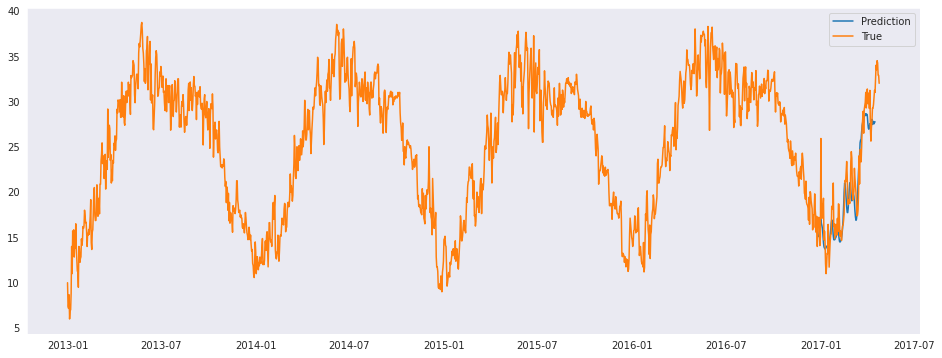

In [214]:
plt.figure(figsize=(16,6))
plt.plot(preddf.loc[:,'meantemp'],label='Prediction')
plt.plot(df['meantemp'],label='True')
plt.legend()
plt.show()



---

